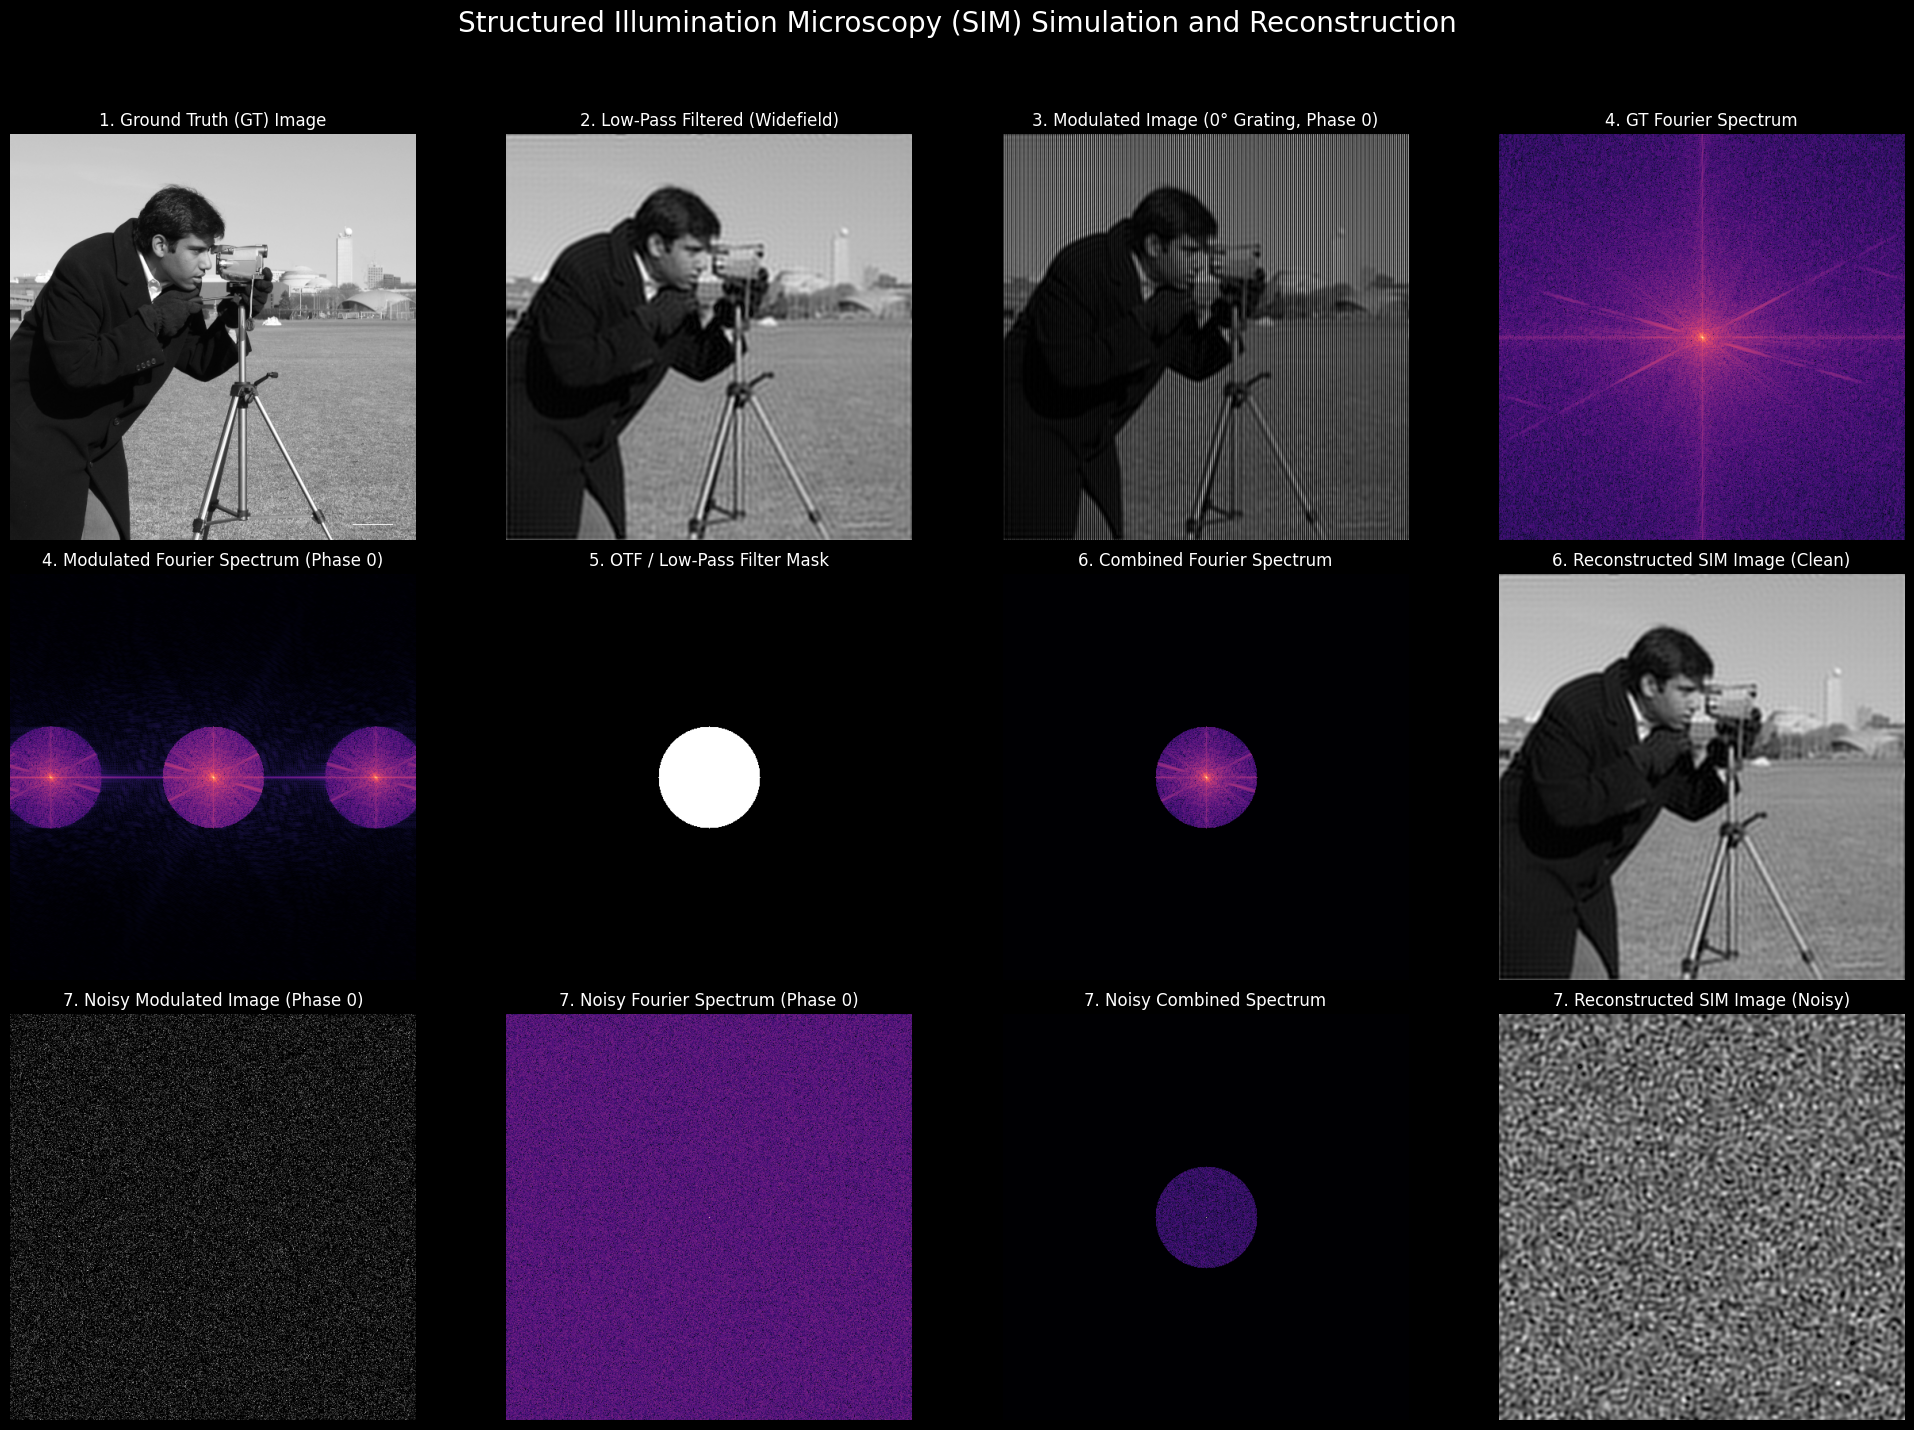

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import camera
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.draw import line
from skimage.util import random_noise
from scipy.ndimage import fourier_shift

#  Generate Ground Truth (GT) Image with Scale Bar
def generate_gt_with_scalebar(image_size=512, bar_length_pixels=50):
    """
    Generates a ground truth image from skimage's 'camera' man
    and adds a scale bar.
    """
    # Use a standard test image and resize it
    gt_image = resize(camera(), (image_size, image_size), anti_aliasing=True)
    gt_image = (gt_image - gt_image.min()) / (gt_image.max() - gt_image.min())

    # Add a scale bar
    bar_pos_y, bar_pos_x_start = image_size - 20, image_size - 30 - bar_length_pixels
    rr, cc = line(bar_pos_y, bar_pos_x_start, bar_pos_y, bar_pos_x_start + bar_length_pixels)
    gt_image[rr, cc] = 1.0 # White bar

    return gt_image

#  Low-Pass Filter the GT Image
def apply_low_pass_filter(image, otf_cutoff=0.25):
    """
    Applies a low-pass filter to simulate the microscope's diffraction limit.
    The cutoff is a fraction of the Nyquist frequency.
    """
    image_fft = np.fft.fftshift(np.fft.fft2(image))

    # Create a circular low-pass filter (Optical Transfer Function)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    radius = int(otf_cutoff * min(crow, ccol))
    mask = np.zeros((rows, cols), np.uint8)
    y, x = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
    mask_area = x*x + y*y <= radius*radius
    mask[mask_area] = 1

    # Apply the filter and inverse transform
    filtered_fft = image_fft * mask
    low_passed_image = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))

    return low_passed_image, mask

#  Simulate Structured Illumination
def simulate_sim_acquisition(low_passed_image, num_angles=3, num_phases=3, k_fraction=0.4):
    """
    Multiplies the low-passed image with grating patterns at different angles.
    """
    image_size = low_passed_image.shape[0]
    modulated_images = []
    grating_vectors = []

    # Define grating vector magnitude (frequency)
    kx_max = ky_max = image_size / 2.0
    k = k_fraction * min(kx_max, ky_max)

    angles = np.linspace(0, 180, num_angles, endpoint=False)
    phases = np.linspace(0, 2 * np.pi, num_phases, endpoint=False)

    x = np.arange(image_size) - image_size / 2
    xx, yy = np.meshgrid(x, x)

    for angle_deg in angles: # Outer loop for angles
        angle_rad = np.deg2rad(angle_deg)
        kx = k * np.cos(angle_rad)
        ky = k * np.sin(angle_rad)
        grating_vectors.append((ky, kx)) # Store in (ky, kx) format for fourier_shift

        images_for_angle = []
        for phase in phases: # INNER LOOP FOR PHASE-SHIFTING
            grating = 0.5 * (1 + np.cos(2 * np.pi * (kx * xx + ky * yy) + phase))
            modulated = low_passed_image * grating
            images_for_angle.append(modulated)
        modulated_images.append(images_for_angle) # Appends a list of images for each angle

    return modulated_images, grating_vectors


def reconstruct_sim(modulated_images_by_angle, otf_mask, grating_vectors):
    """
    Performs SIM reconstruction using algebraic component separation,
    sub-pixel shifting, and a weighted-average merge.

    NOTE: The function inputs are different from the original. It now needs
    images grouped by angle and the grating vectors from the simulation.
    """
    image_size = modulated_images_by_angle[0][0].shape[0]


    # Initialize accumulators for the final spectrum and the weights (masks).
    final_fft = np.zeros((image_size, image_size), dtype=np.complex128)
    sum_of_masks = np.zeros((image_size, image_size), dtype=float)

    # Reconstructor matrix for 3-phase SIM
    M_inv = np.array([
        [1, np.cos(0), np.sin(0)],
        [1, np.cos(2*np.pi/3), np.sin(2*np.pi/3)],
        [1, np.cos(4*np.pi/3), np.sin(4*np.pi/3)]
    ])
    M = np.linalg.inv(M_inv)

    # Process each angle's set of phase-shifted images
    for i in range(len(modulated_images_by_angle)):

        # <<< 1. PROPER COMPONENT SEPARATION >>>
        # This block replaces the incorrect "masking" method.
        # It uses matrix math to algebraically solve for the pure components.
        ffts = [np.fft.fftshift(np.fft.fft2(img)) for img in modulated_images_by_angle[i]]
        ffts = np.stack(ffts, axis=0)

        D = np.array([ffts[0], ffts[1], ffts[2]])
        C = np.einsum('ij,jkl->ikl', M, D)

        c0 = C[0]
        c_plus_conj = C[1] - 1j * C[2]
        c_minus_conj = C[1] + 1j * C[2]
        # <<< END OF COMPONENT SEPARATION >>>

        # This block replaces the inaccurate `np.roll`.
        # It uses `fourier_shift` for precise, non-integer shifting.
        k_vec = grating_vectors[i]

        comp0 = c0 * otf_mask

        shifted_otf_plus = fourier_shift(otf_mask, shift=-np.array(k_vec))
        comp_plus = c_minus_conj * shifted_otf_plus
        comp_plus_shifted = fourier_shift(comp_plus, shift=np.array(k_vec))

        shifted_otf_minus = fourier_shift(otf_mask, shift=np.array(k_vec))
        comp_minus = c_plus_conj * shifted_otf_minus
        comp_minus_shifted = fourier_shift(comp_minus, shift=-np.array(k_vec))
        # <<< END OF SUB-PIXEL SHIFTING >>>

        # This replaces the `np.where` pasting. It adds all components
        # together, allowing them to be averaged in the next step.
        final_fft += comp0 + comp_plus_shifted + comp_minus_shifted
        sum_of_masks += otf_mask + np.abs(shifted_otf_plus) + np.abs(shifted_otf_minus)

    # This final step performs the weighted average by dividing by the sum of weights.
    sum_of_masks[sum_of_masks == 0] = 1 # Avoid division by zero
    final_fft /= sum_of_masks

    # Final filtering (apodization) to reduce ringing artifacts
    final_otf_mask, _ = apply_low_pass_filter(np.ones_like(final_fft), otf_cutoff=OTF_CUTOFF + K_FRACTION)
    reconstructed_image = np.abs(np.fft.ifft2(np.fft.ifftshift(final_fft * final_otf_mask)))

    return reconstructed_image, final_fft


# Main Execution Block
if __name__ == "__main__":
    IMAGE_SIZE = 512
    OTF_CUTOFF = 0.25
    K_FRACTION = 0.4
    NUM_PHASES = 3


    gt_image = generate_gt_with_scalebar(IMAGE_SIZE)


    widefield_image, otf_mask = apply_low_pass_filter(gt_image, OTF_CUTOFF)

    modulated_images_clean, grating_vectors = simulate_sim_acquisition(widefield_image, num_phases=NUM_PHASES)


    gt_fft = np.fft.fftshift(np.fft.fft2(gt_image))
    mod_fft_clean = np.fft.fftshift(np.fft.fft2(modulated_images_clean[0][0])) # Access the first image of the first angle


    reconstructed_image_clean, final_fft_clean = reconstruct_sim(modulated_images_clean, otf_mask, grating_vectors)


    noisy_modulated_images = []
    for angle_images in modulated_images_clean:
        noisy_angle_images = []
        for img in angle_images:
            # Scale image to simulate photon counts for Poisson noise
            img_photons = img * 500
            noisy_img = random_noise(img_photons, mode='poisson') / 500
            # Add Gaussian read noise
            noisy_img = random_noise(noisy_img, mode='gaussian', var=0.001)
            noisy_angle_images.append(noisy_img)
        noisy_modulated_images.append(noisy_angle_images)

    mod_fft_noisy = np.fft.fftshift(np.fft.fft2(noisy_modulated_images[0][0])) # Access the first image of the first angle
    reconstructed_image_noisy, final_fft_noisy = reconstruct_sim(noisy_modulated_images, otf_mask, grating_vectors)

    plt.style.use('dark_background')
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle("Structured Illumination Microscopy (SIM) Simulation and Reconstruction", fontsize=20)

    # Row 1: Ground Truth and Widefield
    axes[0, 0].imshow(gt_image, cmap='gray')
    axes[0, 0].set_title("1. Ground Truth (GT) Image")
    axes[0, 1].imshow(widefield_image, cmap='gray')
    axes[0, 1].set_title("2. Low-Pass Filtered (Widefield)")
    axes[0, 2].imshow(modulated_images_clean[0][0], cmap='gray') # Access the first image of the first angle
    axes[0, 2].set_title("3. Modulated Image (0° Grating, Phase 0)")
    axes[0, 3].imshow(np.log(1 + np.abs(gt_fft)), cmap='magma')
    axes[0, 3].set_title("4. GT Fourier Spectrum")

    # Row 2: Frequency Domain Analysis (Clean)
    axes[1, 0].imshow(np.log(1 + np.abs(mod_fft_clean)), cmap='magma')
    axes[1, 0].set_title("4. Modulated Fourier Spectrum (Phase 0)")
    axes[1, 1].imshow(otf_mask, cmap='gray')
    axes[1, 1].set_title("5. OTF / Low-Pass Filter Mask")
    axes[1, 2].imshow(np.log(1 + np.abs(final_fft_clean)), cmap='magma')
    axes[1, 2].set_title("6. Combined Fourier Spectrum")
    axes[1, 3].imshow(reconstructed_image_clean, cmap='gray')
    axes[1, 3].set_title("6. Reconstructed SIM Image (Clean)")

    # Row 3: Noise Analysis
    axes[2, 0].imshow(noisy_modulated_images[0][0], cmap='gray') # Access the first image of the first angle
    axes[2, 0].set_title("7. Noisy Modulated Image (Phase 0)")
    axes[2, 1].imshow(np.log(1 + np.abs(mod_fft_noisy)), cmap='magma')
    axes[2, 1].set_title("7. Noisy Fourier Spectrum (Phase 0)")
    axes[2, 2].imshow(np.log(1 + np.abs(final_fft_noisy)), cmap='magma')
    axes[2, 2].set_title("7. Noisy Combined Spectrum")
    axes[2, 3].imshow(reconstructed_image_noisy, cmap='gray')
    axes[2, 3].set_title("7. Reconstructed SIM Image (Noisy)")

    for ax_row in axes:
        for ax in ax_row:
            ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()